In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import itertools
import logging
import os.path as osp
import tempfile

import mmcv
import numpy as np
from mmcv.utils import print_log
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

try:
    import pycocotools
    assert pycocotools.__version__ >= '12.0.2'
except AssertionError:
    raise AssertionError('Incompatible version of pycocotools is installed. '
                         'Run pip uninstall pycocotools first. Then run pip '
                         'install mmpycocotools to install open-mmlab forked '
                         'pycocotools.')

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        """Load annotation from COCO style annotation file.

        Args:
            ann_file (str): Path of annotation file.

        Returns:
            list[dict]: Annotation info from COCO api.
        """

        self.coco = COCO(ann_file)
        self.cat_ids = self.coco.get_cat_ids(cat_names=self.CLASSES)
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.img_ids = self.coco.get_img_ids()
        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def get_ann_info(self, idx):
        """Get COCO annotation by index.

        Args:
            idx (int): Index of data.

        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

    def get_cat_ids(self, idx):
        """Get COCO category ids by index.

        Args:
            idx (int): Index of data.

        Returns:
            list[int]: All categories in the image of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return [ann['category_id'] for ann in ann_info]

    def _filter_imgs(self, min_size=32):
        """Filter images too small or without ground truths."""
        valid_inds = []
        ids_with_ann = set(_['image_id'] for _ in self.coco.anns.values())
        for i, img_info in enumerate(self.data_infos):
            if self.filter_empty_gt and self.img_ids[i] not in ids_with_ann:
                continue
            if min(img_info['width'], img_info['height']) >= min_size:
                valid_inds.append(i)
        return valid_inds

    def get_subset_by_classes(self):
        """Get img ids that contain any category in class_ids.

        Different from the coco.getImgIds(), this function returns the id if
        the img contains one of the categories rather than all.

        Args:
            class_ids (list[int]): list of category ids

        Return:
            ids (list[int]): integer list of img ids
        """

        ids = set()
        for i, class_id in enumerate(self.cat_ids):
            ids |= set(self.coco.cat_img_map[class_id])
        self.img_ids = list(ids)

        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def _parse_ann_info(self, img_info, ann_info):
        """Parse bbox and mask annotation.

        Args:
            ann_info (list[dict]): Annotation info of an image.
            with_mask (bool): Whether to parse mask annotations.

        Returns:
            dict: A dict containing the following keys: bboxes, bboxes_ignore,\
                labels, masks, seg_map. "masks" are raw annotations and not \
                decoded into binary masks.
        """
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_masks_ann = []
        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]
            if ann.get('iscrowd', False):
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])
                gt_masks_ann.append(ann.get('segmentation', None))

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        seg_map = img_info['filename'].replace('jpg', 'png')

        ann = dict(
            bboxes=gt_bboxes,
            labels=gt_labels,
            bboxes_ignore=gt_bboxes_ignore,
            masks=gt_masks_ann,
            seg_map=seg_map)

        return ann

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/detectors/detectors_cascade_rcnn_r50_1x_coco.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'datasets/'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'datasets/'
cfg.data.train.ann_file = 'train/traincoco.json'
cfg.data.train.img_prefix = 'train/images/'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'datasets/'
cfg.data.val.ann_file = 'val/valcoco.json'
cfg.data.val.img_prefix = 'val/images/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'datasets/'
cfg.data.test.ann_file = 'test/testcoco.json'
cfg.data.test.img_prefix = 'test/images/'

# num classes of the model in box head
for i, bb_hd in enumerate(cfg.model.roi_head.bbox_head):
    bb_hd.num_classes = 22
cfg.work_dir = './tutorial_exps'

cfg.data.samples_per_gpu = 1
# cfg.model.backbone.depth = 101

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CascadeRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='DetectoRS_ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        conv_cfg=dict(type='ConvAWS'),
        sac=dict(type='SAC', use_deform=True),
        stage_with_sac=(False, True, True, True),
        output_img=True),
    neck=dict(
        type='RFP',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5,
        rfp_steps=2,
        aspp_out_channels=64,
        aspp_dilations=(1, 3, 6, 1),
        rfp_backbone=dict(
            rfp_inplanes=256,
            type='DetectoRS_ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            frozen_stages=1,
            norm_cfg=dict(type='BN', requires_grad=True),
            norm_

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2020-10-01 20:06:32,197 - mmdet - INFO - load model from: torchvision://resnet50
2020-10-01 20:06:32,367 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.weight_diff, layer2.0.conv2.switch.weight, layer2.0.conv2.switch.bias, layer2.0.conv2.pre_context.weight, layer2.0.conv2.pre_context.bias, layer2.0.conv2.post_context.weight, layer2.0.conv2.post_context.bias, layer2.0.conv2.offset_s.weight, layer2.0.conv2.offset_s.bias, layer2.0.conv2.offset_l.weight, layer2.0.conv2.offset_l.bias, layer2.1.conv2.weight_diff, layer2.1.conv2.switch.weight, layer2.1.conv2.switch.bias, layer2.1.conv2.pre_context.weight, layer2.1.conv2.pre_context.bias, layer2.1.conv2.post_context.weight, layer2.1.conv2.post_context.bias, layer2.1.conv2.offset_s.weight, layer2.1.conv2.offset_s.bias, layer2.1.conv2.offset_l.weight, layer2.1.conv2.offset_l.bias, layer2.2.conv2.weight_diff, layer

2020-10-01 20:06:33,935 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-10-01 20:06:33,936 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


2020-10-01 20:06:45,592 - mmdet - INFO - Epoch [1][10/1201]	lr: 4.746e-05, eta: 4:19:06, time: 1.079, data_time: 0.209, memory: 5632, loss_rpn_cls: 0.7013, loss_rpn_bbox: 0.0478, s0.loss_cls: 2.9060, s0.acc: 21.9336, s0.loss_bbox: 0.0760, s1.loss_cls: 1.6036, s1.acc: 2.0703, s1.loss_bbox: 0.0171, s2.loss_cls: 0.8404, s2.acc: 0.0977, s2.loss_bbox: 0.0023, loss: 6.1945
2020-10-01 20:06:54,057 - mmdet - INFO - Epoch [1][20/1201]	lr: 9.741e-05, eta: 3:51:00, time: 0.847, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.6970, loss_rpn_bbox: 0.0434, s0.loss_cls: 1.6028, s0.acc: 95.0977, s0.loss_bbox: 0.0721, s1.loss_cls: 1.2157, s1.acc: 68.2812, s1.loss_bbox: 0.0201, s2.loss_cls: 0.7408, s2.acc: 19.2773, s2.loss_bbox: 0.0020, loss: 4.3938
2020-10-01 20:07:02,621 - mmdet - INFO - Epoch [1][30/1201]	lr: 1.474e-04, eta: 3:42:19, time: 0.856, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.6697, loss_rpn_bbox: 0.0643, s0.loss_cls: 0.4571, s0.acc: 94.4336, s0.loss_bbox: 0.1010, s1.loss_cls: 0.2838

2020-10-01 20:10:01,399 - mmdet - INFO - Epoch [1][230/1201]	lr: 1.146e-03, eta: 3:32:19, time: 0.868, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0393, loss_rpn_bbox: 0.0562, s0.loss_cls: 0.7668, s0.acc: 81.9922, s0.loss_bbox: 0.2870, s1.loss_cls: 0.3896, s1.acc: 80.6687, s1.loss_bbox: 0.2778, s2.loss_cls: 0.1861, s2.acc: 82.5274, s2.loss_bbox: 0.1331, loss: 2.1359
2020-10-01 20:10:10,516 - mmdet - INFO - Epoch [1][240/1201]	lr: 1.196e-03, eta: 3:32:18, time: 0.912, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0455, loss_rpn_bbox: 0.0512, s0.loss_cls: 0.6441, s0.acc: 82.9883, s0.loss_bbox: 0.3117, s1.loss_cls: 0.3522, s1.acc: 81.5765, s1.loss_bbox: 0.2598, s2.loss_cls: 0.1872, s2.acc: 80.3868, s2.loss_bbox: 0.1500, loss: 2.0018
2020-10-01 20:10:19,472 - mmdet - INFO - Epoch [1][250/1201]	lr: 1.246e-03, eta: 3:32:07, time: 0.895, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0296, loss_rpn_bbox: 0.0368, s0.loss_cls: 0.6685, s0.acc: 81.4258, s0.loss_bbox: 0.3180, s1.loss_cls: 0

2020-10-01 20:13:19,027 - mmdet - INFO - Epoch [1][450/1201]	lr: 2.245e-03, eta: 3:29:01, time: 0.860, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0134, loss_rpn_bbox: 0.0426, s0.loss_cls: 0.3719, s0.acc: 87.7930, s0.loss_bbox: 0.2525, s1.loss_cls: 0.1769, s1.acc: 88.6093, s1.loss_bbox: 0.2708, s2.loss_cls: 0.0959, s2.acc: 88.2892, s2.loss_bbox: 0.1652, loss: 1.3893
2020-10-01 20:13:27,507 - mmdet - INFO - Epoch [1][460/1201]	lr: 2.295e-03, eta: 3:28:37, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0196, loss_rpn_bbox: 0.0359, s0.loss_cls: 0.3404, s0.acc: 89.6680, s0.loss_bbox: 0.2342, s1.loss_cls: 0.1591, s1.acc: 92.0732, s1.loss_bbox: 0.2483, s2.loss_cls: 0.0913, s2.acc: 89.3814, s2.loss_bbox: 0.1765, loss: 1.3053
2020-10-01 20:13:35,857 - mmdet - INFO - Epoch [1][470/1201]	lr: 2.345e-03, eta: 3:28:10, time: 0.835, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0234, loss_rpn_bbox: 0.0365, s0.loss_cls: 0.3306, s0.acc: 89.7656, s0.loss_bbox: 0.2822, s1.loss_cls: 0

2020-10-01 20:16:27,645 - mmdet - INFO - Epoch [1][670/1201]	lr: 2.500e-03, eta: 3:22:39, time: 0.863, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0186, loss_rpn_bbox: 0.0263, s0.loss_cls: 0.2417, s0.acc: 92.4414, s0.loss_bbox: 0.1746, s1.loss_cls: 0.1016, s1.acc: 94.1076, s1.loss_bbox: 0.2006, s2.loss_cls: 0.0604, s2.acc: 92.4192, s2.loss_bbox: 0.1469, loss: 0.9706
2020-10-01 20:16:36,270 - mmdet - INFO - Epoch [1][680/1201]	lr: 2.500e-03, eta: 3:22:26, time: 0.863, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0142, loss_rpn_bbox: 0.0319, s0.loss_cls: 0.2303, s0.acc: 92.4219, s0.loss_bbox: 0.1646, s1.loss_cls: 0.1086, s1.acc: 93.0941, s1.loss_bbox: 0.1841, s2.loss_cls: 0.0629, s2.acc: 92.0022, s2.loss_bbox: 0.1409, loss: 0.9374
2020-10-01 20:16:44,775 - mmdet - INFO - Epoch [1][690/1201]	lr: 2.500e-03, eta: 3:22:10, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0115, loss_rpn_bbox: 0.0281, s0.loss_cls: 0.2801, s0.acc: 91.2109, s0.loss_bbox: 0.1646, s1.loss_cls: 0

2020-10-01 20:19:37,281 - mmdet - INFO - Epoch [1][890/1201]	lr: 2.500e-03, eta: 3:18:08, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0100, loss_rpn_bbox: 0.0168, s0.loss_cls: 0.1895, s0.acc: 93.7500, s0.loss_bbox: 0.1555, s1.loss_cls: 0.0954, s1.acc: 94.6320, s1.loss_bbox: 0.1790, s2.loss_cls: 0.0491, s2.acc: 94.2332, s2.loss_bbox: 0.1446, loss: 0.8399
2020-10-01 20:19:46,090 - mmdet - INFO - Epoch [1][900/1201]	lr: 2.500e-03, eta: 3:17:59, time: 0.881, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0132, loss_rpn_bbox: 0.0182, s0.loss_cls: 0.2814, s0.acc: 91.8164, s0.loss_bbox: 0.1396, s1.loss_cls: 0.1395, s1.acc: 93.2660, s1.loss_bbox: 0.1574, s2.loss_cls: 0.0786, s2.acc: 92.3546, s2.loss_bbox: 0.1326, loss: 0.9606
2020-10-01 20:19:54,686 - mmdet - INFO - Epoch [1][910/1201]	lr: 2.500e-03, eta: 3:17:48, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0053, loss_rpn_bbox: 0.0192, s0.loss_cls: 0.2655, s0.acc: 93.1836, s0.loss_bbox: 0.1513, s1.loss_cls: 0

2020-10-01 20:22:46,897 - mmdet - INFO - Epoch [1][1110/1201]	lr: 2.500e-03, eta: 3:14:09, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0066, loss_rpn_bbox: 0.0224, s0.loss_cls: 0.1981, s0.acc: 93.9648, s0.loss_bbox: 0.1272, s1.loss_cls: 0.0826, s1.acc: 96.0748, s1.loss_bbox: 0.1489, s2.loss_cls: 0.0458, s2.acc: 95.7303, s2.loss_bbox: 0.1302, loss: 0.7619
2020-10-01 20:22:55,407 - mmdet - INFO - Epoch [1][1120/1201]	lr: 2.500e-03, eta: 3:13:57, time: 0.851, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0066, loss_rpn_bbox: 0.0157, s0.loss_cls: 0.2441, s0.acc: 94.3555, s0.loss_bbox: 0.1235, s1.loss_cls: 0.1184, s1.acc: 95.1868, s1.loss_bbox: 0.1218, s2.loss_cls: 0.0661, s2.acc: 94.9882, s2.loss_bbox: 0.1145, loss: 0.8107
2020-10-01 20:23:04,137 - mmdet - INFO - Epoch [1][1130/1201]	lr: 2.500e-03, eta: 3:13:48, time: 0.873, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0080, loss_rpn_bbox: 0.0270, s0.loss_cls: 0.2050, s0.acc: 94.2773, s0.loss_bbox: 0.1208, s1.loss_cls

2020-10-01 20:25:59,402 - mmdet - INFO - Epoch [2][130/1201]	lr: 2.500e-03, eta: 3:10:35, time: 0.870, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0063, loss_rpn_bbox: 0.0187, s0.loss_cls: 0.1603, s0.acc: 95.1953, s0.loss_bbox: 0.1155, s1.loss_cls: 0.0807, s1.acc: 95.8233, s1.loss_bbox: 0.1254, s2.loss_cls: 0.0429, s2.acc: 96.1855, s2.loss_bbox: 0.1152, loss: 0.6649
2020-10-01 20:26:08,096 - mmdet - INFO - Epoch [2][140/1201]	lr: 2.500e-03, eta: 3:10:26, time: 0.869, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0178, s0.loss_cls: 0.1563, s0.acc: 95.0586, s0.loss_bbox: 0.1063, s1.loss_cls: 0.0706, s1.acc: 96.2730, s1.loss_bbox: 0.1199, s2.loss_cls: 0.0371, s2.acc: 96.6316, s2.loss_bbox: 0.1102, loss: 0.6225
2020-10-01 20:26:16,693 - mmdet - INFO - Epoch [2][150/1201]	lr: 2.500e-03, eta: 3:10:16, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0212, s0.loss_cls: 0.1722, s0.acc: 94.8633, s0.loss_bbox: 0.1036, s1.loss_cls: 0

2020-10-01 20:29:09,044 - mmdet - INFO - Epoch [2][350/1201]	lr: 2.500e-03, eta: 3:07:01, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0046, loss_rpn_bbox: 0.0165, s0.loss_cls: 0.1827, s0.acc: 95.0781, s0.loss_bbox: 0.0861, s1.loss_cls: 0.0751, s1.acc: 97.1133, s1.loss_bbox: 0.1075, s2.loss_cls: 0.0385, s2.acc: 96.8227, s2.loss_bbox: 0.0948, loss: 0.6057
2020-10-01 20:29:17,524 - mmdet - INFO - Epoch [2][360/1201]	lr: 2.500e-03, eta: 3:06:50, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0095, loss_rpn_bbox: 0.0190, s0.loss_cls: 0.1809, s0.acc: 95.4102, s0.loss_bbox: 0.0841, s1.loss_cls: 0.0791, s1.acc: 96.9455, s1.loss_bbox: 0.1048, s2.loss_cls: 0.0407, s2.acc: 96.9580, s2.loss_bbox: 0.0939, loss: 0.6121
2020-10-01 20:29:26,107 - mmdet - INFO - Epoch [2][370/1201]	lr: 2.500e-03, eta: 3:06:40, time: 0.858, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0125, s0.loss_cls: 0.1518, s0.acc: 95.7031, s0.loss_bbox: 0.0955, s1.loss_cls: 0

2020-10-01 20:32:18,267 - mmdet - INFO - Epoch [2][570/1201]	lr: 2.500e-03, eta: 3:03:29, time: 0.852, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0123, s0.loss_cls: 0.1553, s0.acc: 95.4492, s0.loss_bbox: 0.1008, s1.loss_cls: 0.0668, s1.acc: 96.6810, s1.loss_bbox: 0.1145, s2.loss_cls: 0.0343, s2.acc: 96.6377, s2.loss_bbox: 0.1098, loss: 0.5973
2020-10-01 20:32:27,012 - mmdet - INFO - Epoch [2][580/1201]	lr: 2.500e-03, eta: 3:03:21, time: 0.874, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0078, loss_rpn_bbox: 0.0147, s0.loss_cls: 0.1419, s0.acc: 95.5273, s0.loss_bbox: 0.1006, s1.loss_cls: 0.0638, s1.acc: 96.6288, s1.loss_bbox: 0.1135, s2.loss_cls: 0.0299, s2.acc: 97.1365, s2.loss_bbox: 0.1026, loss: 0.5748
2020-10-01 20:32:35,442 - mmdet - INFO - Epoch [2][590/1201]	lr: 2.500e-03, eta: 3:03:10, time: 0.843, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0040, loss_rpn_bbox: 0.0115, s0.loss_cls: 0.1488, s0.acc: 95.8594, s0.loss_bbox: 0.0843, s1.loss_cls: 0

2020-10-01 20:35:28,072 - mmdet - INFO - Epoch [2][790/1201]	lr: 2.500e-03, eta: 3:00:06, time: 0.883, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0086, loss_rpn_bbox: 0.0213, s0.loss_cls: 0.1585, s0.acc: 95.4492, s0.loss_bbox: 0.1024, s1.loss_cls: 0.0682, s1.acc: 96.7348, s1.loss_bbox: 0.1224, s2.loss_cls: 0.0353, s2.acc: 96.8492, s2.loss_bbox: 0.0961, loss: 0.6128
2020-10-01 20:35:36,803 - mmdet - INFO - Epoch [2][800/1201]	lr: 2.500e-03, eta: 2:59:58, time: 0.873, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0056, loss_rpn_bbox: 0.0136, s0.loss_cls: 0.1663, s0.acc: 95.2344, s0.loss_bbox: 0.0890, s1.loss_cls: 0.0847, s1.acc: 96.2470, s1.loss_bbox: 0.1076, s2.loss_cls: 0.0398, s2.acc: 96.6663, s2.loss_bbox: 0.0987, loss: 0.6053
2020-10-01 20:35:45,406 - mmdet - INFO - Epoch [2][810/1201]	lr: 2.500e-03, eta: 2:59:49, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0075, loss_rpn_bbox: 0.0150, s0.loss_cls: 0.1383, s0.acc: 95.2344, s0.loss_bbox: 0.0743, s1.loss_cls: 0

2020-10-01 20:38:39,436 - mmdet - INFO - Epoch [2][1010/1201]	lr: 2.500e-03, eta: 2:56:55, time: 0.896, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0182, s0.loss_cls: 0.1828, s0.acc: 95.3906, s0.loss_bbox: 0.0860, s1.loss_cls: 0.0868, s1.acc: 96.6228, s1.loss_bbox: 0.1010, s2.loss_cls: 0.0486, s2.acc: 96.5198, s2.loss_bbox: 0.0993, loss: 0.6268
2020-10-01 20:38:47,960 - mmdet - INFO - Epoch [2][1020/1201]	lr: 2.500e-03, eta: 2:56:45, time: 0.852, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0063, loss_rpn_bbox: 0.0155, s0.loss_cls: 0.1331, s0.acc: 96.3477, s0.loss_bbox: 0.0865, s1.loss_cls: 0.0533, s1.acc: 97.2837, s1.loss_bbox: 0.1037, s2.loss_cls: 0.0313, s2.acc: 96.6093, s2.loss_bbox: 0.1032, loss: 0.5329
2020-10-01 20:38:56,699 - mmdet - INFO - Epoch [2][1030/1201]	lr: 2.500e-03, eta: 2:56:37, time: 0.874, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0136, s0.loss_cls: 0.1221, s0.acc: 96.3086, s0.loss_bbox: 0.0600, s1.loss_cls

2020-10-01 20:41:52,066 - mmdet - INFO - Epoch [3][30/1201]	lr: 2.500e-03, eta: 2:53:40, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0101, s0.loss_cls: 0.1158, s0.acc: 96.1133, s0.loss_bbox: 0.0659, s1.loss_cls: 0.0451, s1.acc: 97.7525, s1.loss_bbox: 0.0913, s2.loss_cls: 0.0256, s2.acc: 97.9192, s2.loss_bbox: 0.0883, loss: 0.4454
2020-10-01 20:42:00,676 - mmdet - INFO - Epoch [3][40/1201]	lr: 2.500e-03, eta: 2:53:31, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0090, s0.loss_cls: 0.1511, s0.acc: 96.1914, s0.loss_bbox: 0.0884, s1.loss_cls: 0.0750, s1.acc: 96.8588, s1.loss_bbox: 0.1111, s2.loss_cls: 0.0467, s2.acc: 96.2170, s2.loss_bbox: 0.1047, loss: 0.5892
2020-10-01 20:42:09,160 - mmdet - INFO - Epoch [3][50/1201]	lr: 2.500e-03, eta: 2:53:21, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0053, loss_rpn_bbox: 0.0120, s0.loss_cls: 0.1249, s0.acc: 95.5859, s0.loss_bbox: 0.0724, s1.loss_cls: 0.05

2020-10-01 20:45:02,487 - mmdet - INFO - Epoch [3][250/1201]	lr: 2.500e-03, eta: 2:50:24, time: 0.852, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0105, s0.loss_cls: 0.1003, s0.acc: 96.5234, s0.loss_bbox: 0.0645, s1.loss_cls: 0.0303, s1.acc: 98.2221, s1.loss_bbox: 0.0975, s2.loss_cls: 0.0169, s2.acc: 98.1420, s2.loss_bbox: 0.0882, loss: 0.4122
2020-10-01 20:45:10,999 - mmdet - INFO - Epoch [3][260/1201]	lr: 2.500e-03, eta: 2:50:15, time: 0.851, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0120, s0.loss_cls: 0.1121, s0.acc: 96.0352, s0.loss_bbox: 0.0737, s1.loss_cls: 0.0458, s1.acc: 97.3907, s1.loss_bbox: 0.0997, s2.loss_cls: 0.0250, s2.acc: 97.2792, s2.loss_bbox: 0.0913, loss: 0.4636
2020-10-01 20:45:19,723 - mmdet - INFO - Epoch [3][270/1201]	lr: 2.500e-03, eta: 2:50:06, time: 0.872, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0121, s0.loss_cls: 0.1232, s0.acc: 95.8984, s0.loss_bbox: 0.0681, s1.loss_cls: 0

2020-10-01 20:48:12,620 - mmdet - INFO - Epoch [3][470/1201]	lr: 2.500e-03, eta: 2:47:08, time: 0.926, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0104, s0.loss_cls: 0.1274, s0.acc: 96.4453, s0.loss_bbox: 0.0615, s1.loss_cls: 0.0542, s1.acc: 97.8842, s1.loss_bbox: 0.0859, s2.loss_cls: 0.0268, s2.acc: 98.6902, s2.loss_bbox: 0.0870, loss: 0.4545
2020-10-01 20:48:21,257 - mmdet - INFO - Epoch [3][480/1201]	lr: 2.500e-03, eta: 2:47:00, time: 0.864, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.1129, s0.acc: 96.3867, s0.loss_bbox: 0.0704, s1.loss_cls: 0.0469, s1.acc: 97.3511, s1.loss_bbox: 0.0873, s2.loss_cls: 0.0233, s2.acc: 98.0330, s2.loss_bbox: 0.0807, loss: 0.4331
2020-10-01 20:48:29,940 - mmdet - INFO - Epoch [3][490/1201]	lr: 2.500e-03, eta: 2:46:51, time: 0.868, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0101, loss_rpn_bbox: 0.0121, s0.loss_cls: 0.1614, s0.acc: 95.1953, s0.loss_bbox: 0.0829, s1.loss_cls: 0

2020-10-01 20:51:22,209 - mmdet - INFO - Epoch [3][690/1201]	lr: 2.500e-03, eta: 2:43:51, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0128, s0.loss_cls: 0.1065, s0.acc: 96.7578, s0.loss_bbox: 0.0652, s1.loss_cls: 0.0403, s1.acc: 98.0541, s1.loss_bbox: 0.0889, s2.loss_cls: 0.0198, s2.acc: 98.4627, s2.loss_bbox: 0.0902, loss: 0.4260
2020-10-01 20:51:30,816 - mmdet - INFO - Epoch [3][700/1201]	lr: 2.500e-03, eta: 2:43:42, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0103, s0.loss_cls: 0.1144, s0.acc: 96.6016, s0.loss_bbox: 0.0718, s1.loss_cls: 0.0425, s1.acc: 97.6100, s1.loss_bbox: 0.0773, s2.loss_cls: 0.0225, s2.acc: 97.5785, s2.loss_bbox: 0.0696, loss: 0.4099
2020-10-01 20:51:39,205 - mmdet - INFO - Epoch [3][710/1201]	lr: 2.500e-03, eta: 2:43:33, time: 0.839, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.1074, s0.acc: 96.7383, s0.loss_bbox: 0.0592, s1.loss_cls: 0

2020-10-01 20:54:32,287 - mmdet - INFO - Epoch [3][910/1201]	lr: 2.500e-03, eta: 2:40:37, time: 0.873, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0100, s0.loss_cls: 0.1332, s0.acc: 96.5234, s0.loss_bbox: 0.0537, s1.loss_cls: 0.0570, s1.acc: 98.3258, s1.loss_bbox: 0.0835, s2.loss_cls: 0.0363, s2.acc: 98.0727, s2.loss_bbox: 0.0798, loss: 0.4566
2020-10-01 20:54:41,095 - mmdet - INFO - Epoch [3][920/1201]	lr: 2.500e-03, eta: 2:40:29, time: 0.881, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0109, s0.loss_cls: 0.1188, s0.acc: 96.7969, s0.loss_bbox: 0.0704, s1.loss_cls: 0.0567, s1.acc: 98.0189, s1.loss_bbox: 0.0989, s2.loss_cls: 0.0314, s2.acc: 97.7393, s2.loss_bbox: 0.0920, loss: 0.4827
2020-10-01 20:54:49,582 - mmdet - INFO - Epoch [3][930/1201]	lr: 2.500e-03, eta: 2:40:19, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0133, s0.loss_cls: 0.0928, s0.acc: 97.1289, s0.loss_bbox: 0.0513, s1.loss_cls: 0

2020-10-01 20:57:42,831 - mmdet - INFO - Epoch [3][1130/1201]	lr: 2.500e-03, eta: 2:37:25, time: 0.884, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0076, s0.loss_cls: 0.1331, s0.acc: 96.2500, s0.loss_bbox: 0.0632, s1.loss_cls: 0.0663, s1.acc: 97.7507, s1.loss_bbox: 0.0806, s2.loss_cls: 0.0393, s2.acc: 97.3993, s2.loss_bbox: 0.0788, loss: 0.4739
2020-10-01 20:57:51,333 - mmdet - INFO - Epoch [3][1140/1201]	lr: 2.500e-03, eta: 2:37:15, time: 0.850, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.1003, s0.acc: 96.8164, s0.loss_bbox: 0.0544, s1.loss_cls: 0.0506, s1.acc: 97.3505, s1.loss_bbox: 0.0862, s2.loss_cls: 0.0264, s2.acc: 97.8613, s2.loss_bbox: 0.0868, loss: 0.4156
2020-10-01 20:57:59,724 - mmdet - INFO - Epoch [3][1150/1201]	lr: 2.500e-03, eta: 2:37:06, time: 0.839, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0920, s0.acc: 96.9336, s0.loss_bbox: 0.0622, s1.loss_cls

2020-10-01 21:00:55,729 - mmdet - INFO - Epoch [4][150/1201]	lr: 2.500e-03, eta: 2:34:13, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0135, s0.loss_cls: 0.1246, s0.acc: 96.3281, s0.loss_bbox: 0.0670, s1.loss_cls: 0.0601, s1.acc: 97.4901, s1.loss_bbox: 0.0882, s2.loss_cls: 0.0362, s2.acc: 97.5380, s2.loss_bbox: 0.0796, loss: 0.4736
2020-10-01 21:01:04,463 - mmdet - INFO - Epoch [4][160/1201]	lr: 2.500e-03, eta: 2:34:05, time: 0.873, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.1366, s0.acc: 96.0742, s0.loss_bbox: 0.0734, s1.loss_cls: 0.0593, s1.acc: 97.5894, s1.loss_bbox: 0.0994, s2.loss_cls: 0.0370, s2.acc: 97.2113, s2.loss_bbox: 0.0919, loss: 0.5094
2020-10-01 21:01:13,187 - mmdet - INFO - Epoch [4][170/1201]	lr: 2.500e-03, eta: 2:33:56, time: 0.872, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0098, s0.loss_cls: 0.1137, s0.acc: 96.0742, s0.loss_bbox: 0.0669, s1.loss_cls: 0

2020-10-01 21:04:06,263 - mmdet - INFO - Epoch [4][370/1201]	lr: 2.500e-03, eta: 2:31:01, time: 0.851, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0079, s0.loss_cls: 0.0899, s0.acc: 97.0703, s0.loss_bbox: 0.0500, s1.loss_cls: 0.0370, s1.acc: 98.2385, s1.loss_bbox: 0.0629, s2.loss_cls: 0.0179, s2.acc: 98.6969, s2.loss_bbox: 0.0579, loss: 0.3254
2020-10-01 21:04:14,984 - mmdet - INFO - Epoch [4][380/1201]	lr: 2.500e-03, eta: 2:30:52, time: 0.872, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0077, s0.loss_cls: 0.0920, s0.acc: 97.0703, s0.loss_bbox: 0.0572, s1.loss_cls: 0.0453, s1.acc: 97.9686, s1.loss_bbox: 0.0806, s2.loss_cls: 0.0248, s2.acc: 98.1985, s2.loss_bbox: 0.0743, loss: 0.3861
2020-10-01 21:04:23,376 - mmdet - INFO - Epoch [4][390/1201]	lr: 2.500e-03, eta: 2:30:43, time: 0.839, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0960, s0.acc: 96.9531, s0.loss_bbox: 0.0534, s1.loss_cls: 0

2020-10-01 21:07:15,892 - mmdet - INFO - Epoch [4][590/1201]	lr: 2.500e-03, eta: 2:27:47, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0087, s0.loss_cls: 0.1146, s0.acc: 96.4258, s0.loss_bbox: 0.0529, s1.loss_cls: 0.0496, s1.acc: 97.2788, s1.loss_bbox: 0.0780, s2.loss_cls: 0.0235, s2.acc: 97.9518, s2.loss_bbox: 0.0762, loss: 0.4058
2020-10-01 21:07:24,377 - mmdet - INFO - Epoch [4][600/1201]	lr: 2.500e-03, eta: 2:27:38, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0104, s0.loss_cls: 0.0997, s0.acc: 96.8359, s0.loss_bbox: 0.0522, s1.loss_cls: 0.0339, s1.acc: 98.1347, s1.loss_bbox: 0.0728, s2.loss_cls: 0.0202, s2.acc: 97.9473, s2.loss_bbox: 0.0753, loss: 0.3670
2020-10-01 21:07:33,079 - mmdet - INFO - Epoch [4][610/1201]	lr: 2.500e-03, eta: 2:27:29, time: 0.870, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0117, s0.loss_cls: 0.0960, s0.acc: 97.1289, s0.loss_bbox: 0.0495, s1.loss_cls: 0

2020-10-01 21:10:25,469 - mmdet - INFO - Epoch [4][810/1201]	lr: 2.500e-03, eta: 2:24:33, time: 0.860, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0073, s0.loss_cls: 0.0995, s0.acc: 96.8555, s0.loss_bbox: 0.0689, s1.loss_cls: 0.0474, s1.acc: 97.8705, s1.loss_bbox: 0.0804, s2.loss_cls: 0.0269, s2.acc: 97.4964, s2.loss_bbox: 0.0753, loss: 0.4073
2020-10-01 21:10:34,124 - mmdet - INFO - Epoch [4][820/1201]	lr: 2.500e-03, eta: 2:24:24, time: 0.865, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0074, s0.loss_cls: 0.0704, s0.acc: 97.6562, s0.loss_bbox: 0.0604, s1.loss_cls: 0.0270, s1.acc: 98.7996, s1.loss_bbox: 0.0709, s2.loss_cls: 0.0150, s2.acc: 99.0844, s2.loss_bbox: 0.0729, loss: 0.3266
2020-10-01 21:10:42,726 - mmdet - INFO - Epoch [4][830/1201]	lr: 2.500e-03, eta: 2:24:15, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0939, s0.acc: 97.4219, s0.loss_bbox: 0.0457, s1.loss_cls: 0

2020-10-01 21:13:34,502 - mmdet - INFO - Epoch [4][1030/1201]	lr: 2.500e-03, eta: 2:21:18, time: 0.871, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0095, s0.loss_cls: 0.1142, s0.acc: 96.4844, s0.loss_bbox: 0.0509, s1.loss_cls: 0.0453, s1.acc: 98.1392, s1.loss_bbox: 0.0818, s2.loss_cls: 0.0272, s2.acc: 98.1360, s2.loss_bbox: 0.0828, loss: 0.4139
2020-10-01 21:13:43,213 - mmdet - INFO - Epoch [4][1040/1201]	lr: 2.500e-03, eta: 2:21:10, time: 0.871, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0102, s0.loss_cls: 0.1052, s0.acc: 96.7969, s0.loss_bbox: 0.0673, s1.loss_cls: 0.0544, s1.acc: 98.0120, s1.loss_bbox: 0.0877, s2.loss_cls: 0.0348, s2.acc: 98.0377, s2.loss_bbox: 0.0760, loss: 0.4401
2020-10-01 21:13:51,705 - mmdet - INFO - Epoch [4][1050/1201]	lr: 2.500e-03, eta: 2:21:01, time: 0.849, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0097, s0.loss_cls: 0.0788, s0.acc: 97.4805, s0.loss_bbox: 0.0619, s1.loss_cls

2020-10-01 21:16:47,644 - mmdet - INFO - Epoch [5][50/1201]	lr: 2.500e-03, eta: 2:18:08, time: 0.872, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0740, s0.acc: 97.5391, s0.loss_bbox: 0.0465, s1.loss_cls: 0.0310, s1.acc: 98.4448, s1.loss_bbox: 0.0689, s2.loss_cls: 0.0156, s2.acc: 99.2449, s2.loss_bbox: 0.0666, loss: 0.3123
2020-10-01 21:16:56,245 - mmdet - INFO - Epoch [5][60/1201]	lr: 2.500e-03, eta: 2:17:59, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0085, s0.loss_cls: 0.0795, s0.acc: 97.3438, s0.loss_bbox: 0.0477, s1.loss_cls: 0.0373, s1.acc: 98.6598, s1.loss_bbox: 0.0753, s2.loss_cls: 0.0203, s2.acc: 99.0687, s2.loss_bbox: 0.0785, loss: 0.3486
2020-10-01 21:17:04,968 - mmdet - INFO - Epoch [5][70/1201]	lr: 2.500e-03, eta: 2:17:50, time: 0.872, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0096, s0.loss_cls: 0.1050, s0.acc: 96.5039, s0.loss_bbox: 0.0573, s1.loss_cls: 0.04

2020-10-01 21:19:57,789 - mmdet - INFO - Epoch [5][270/1201]	lr: 2.500e-03, eta: 2:14:56, time: 0.883, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0648, s0.acc: 97.5195, s0.loss_bbox: 0.0361, s1.loss_cls: 0.0268, s1.acc: 98.5103, s1.loss_bbox: 0.0546, s2.loss_cls: 0.0137, s2.acc: 98.5521, s2.loss_bbox: 0.0567, loss: 0.2607
2020-10-01 21:20:06,290 - mmdet - INFO - Epoch [5][280/1201]	lr: 2.500e-03, eta: 2:14:47, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0571, s0.acc: 97.8320, s0.loss_bbox: 0.0395, s1.loss_cls: 0.0230, s1.acc: 98.8980, s1.loss_bbox: 0.0602, s2.loss_cls: 0.0140, s2.acc: 99.0730, s2.loss_bbox: 0.0669, loss: 0.2669
2020-10-01 21:20:14,791 - mmdet - INFO - Epoch [5][290/1201]	lr: 2.500e-03, eta: 2:14:38, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0656, s0.acc: 97.6758, s0.loss_bbox: 0.0417, s1.loss_cls: 0

2020-10-01 21:23:09,244 - mmdet - INFO - Epoch [5][490/1201]	lr: 2.500e-03, eta: 2:11:46, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0062, s0.loss_cls: 0.0739, s0.acc: 97.5781, s0.loss_bbox: 0.0445, s1.loss_cls: 0.0295, s1.acc: 98.6901, s1.loss_bbox: 0.0585, s2.loss_cls: 0.0162, s2.acc: 98.9839, s2.loss_bbox: 0.0560, loss: 0.2867
2020-10-01 21:23:17,840 - mmdet - INFO - Epoch [5][500/1201]	lr: 2.500e-03, eta: 2:11:38, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0078, s0.loss_cls: 0.0741, s0.acc: 97.5000, s0.loss_bbox: 0.0548, s1.loss_cls: 0.0289, s1.acc: 98.2701, s1.loss_bbox: 0.0657, s2.loss_cls: 0.0150, s2.acc: 98.6645, s2.loss_bbox: 0.0659, loss: 0.3154
2020-10-01 21:23:26,450 - mmdet - INFO - Epoch [5][510/1201]	lr: 2.500e-03, eta: 2:11:29, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0095, s0.loss_cls: 0.0722, s0.acc: 97.4219, s0.loss_bbox: 0.0492, s1.loss_cls: 0

2020-10-01 21:26:18,838 - mmdet - INFO - Epoch [5][710/1201]	lr: 2.500e-03, eta: 2:08:34, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0102, s0.loss_cls: 0.0821, s0.acc: 97.1875, s0.loss_bbox: 0.0639, s1.loss_cls: 0.0402, s1.acc: 98.1949, s1.loss_bbox: 0.0908, s2.loss_cls: 0.0309, s2.acc: 98.1788, s2.loss_bbox: 0.0795, loss: 0.3992
2020-10-01 21:26:27,370 - mmdet - INFO - Epoch [5][720/1201]	lr: 2.500e-03, eta: 2:08:25, time: 0.853, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0659, s0.acc: 97.4023, s0.loss_bbox: 0.0442, s1.loss_cls: 0.0241, s1.acc: 98.7420, s1.loss_bbox: 0.0693, s2.loss_cls: 0.0130, s2.acc: 99.0933, s2.loss_bbox: 0.0679, loss: 0.2935
2020-10-01 21:26:36,101 - mmdet - INFO - Epoch [5][730/1201]	lr: 2.500e-03, eta: 2:08:16, time: 0.873, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.1054, s0.acc: 96.6602, s0.loss_bbox: 0.0459, s1.loss_cls: 0

2020-10-01 21:29:28,082 - mmdet - INFO - Epoch [5][930/1201]	lr: 2.500e-03, eta: 2:05:21, time: 0.871, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0072, s0.loss_cls: 0.0688, s0.acc: 97.2852, s0.loss_bbox: 0.0436, s1.loss_cls: 0.0240, s1.acc: 98.3825, s1.loss_bbox: 0.0588, s2.loss_cls: 0.0128, s2.acc: 98.6619, s2.loss_bbox: 0.0585, loss: 0.2763
2020-10-01 21:29:36,689 - mmdet - INFO - Epoch [5][940/1201]	lr: 2.500e-03, eta: 2:05:12, time: 0.861, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0979, s0.acc: 96.8945, s0.loss_bbox: 0.0518, s1.loss_cls: 0.0446, s1.acc: 97.6843, s1.loss_bbox: 0.0724, s2.loss_cls: 0.0250, s2.acc: 97.4550, s2.loss_bbox: 0.0664, loss: 0.3690
2020-10-01 21:29:45,293 - mmdet - INFO - Epoch [5][950/1201]	lr: 2.500e-03, eta: 2:05:03, time: 0.860, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0099, s0.loss_cls: 0.0903, s0.acc: 96.6797, s0.loss_bbox: 0.0454, s1.loss_cls: 0

2020-10-01 21:32:37,903 - mmdet - INFO - Epoch [5][1150/1201]	lr: 2.500e-03, eta: 2:02:09, time: 0.848, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0066, s0.loss_cls: 0.0620, s0.acc: 97.8320, s0.loss_bbox: 0.0459, s1.loss_cls: 0.0271, s1.acc: 98.5990, s1.loss_bbox: 0.0675, s2.loss_cls: 0.0165, s2.acc: 98.7934, s2.loss_bbox: 0.0664, loss: 0.2959
2020-10-01 21:32:46,489 - mmdet - INFO - Epoch [5][1160/1201]	lr: 2.500e-03, eta: 2:02:00, time: 0.859, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0092, s0.loss_cls: 0.0790, s0.acc: 97.5000, s0.loss_bbox: 0.0461, s1.loss_cls: 0.0379, s1.acc: 98.5068, s1.loss_bbox: 0.0692, s2.loss_cls: 0.0209, s2.acc: 98.7940, s2.loss_bbox: 0.0711, loss: 0.3359
2020-10-01 21:32:54,968 - mmdet - INFO - Epoch [5][1170/1201]	lr: 2.500e-03, eta: 2:01:51, time: 0.848, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0086, s0.loss_cls: 0.0688, s0.acc: 97.4414, s0.loss_bbox: 0.0508, s1.loss_cls

2020-10-01 21:35:50,279 - mmdet - INFO - Epoch [6][170/1201]	lr: 2.500e-03, eta: 1:58:57, time: 0.869, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0078, s0.loss_cls: 0.0574, s0.acc: 97.8516, s0.loss_bbox: 0.0582, s1.loss_cls: 0.0160, s1.acc: 98.8582, s1.loss_bbox: 0.0592, s2.loss_cls: 0.0067, s2.acc: 99.4555, s2.loss_bbox: 0.0533, loss: 0.2613
2020-10-01 21:35:58,755 - mmdet - INFO - Epoch [6][180/1201]	lr: 2.500e-03, eta: 1:58:48, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0056, s0.loss_cls: 0.0576, s0.acc: 97.7734, s0.loss_bbox: 0.0516, s1.loss_cls: 0.0245, s1.acc: 98.7001, s1.loss_bbox: 0.0650, s2.loss_cls: 0.0126, s2.acc: 98.9748, s2.loss_bbox: 0.0699, loss: 0.2876
2020-10-01 21:36:07,458 - mmdet - INFO - Epoch [6][190/1201]	lr: 2.500e-03, eta: 1:58:40, time: 0.870, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0078, s0.loss_cls: 0.0960, s0.acc: 96.9531, s0.loss_bbox: 0.0474, s1.loss_cls: 0

2020-10-01 21:39:00,464 - mmdet - INFO - Epoch [6][390/1201]	lr: 2.500e-03, eta: 1:55:46, time: 0.869, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0531, s0.acc: 98.0469, s0.loss_bbox: 0.0391, s1.loss_cls: 0.0201, s1.acc: 98.8875, s1.loss_bbox: 0.0606, s2.loss_cls: 0.0100, s2.acc: 99.1731, s2.loss_bbox: 0.0588, loss: 0.2478
2020-10-01 21:39:09,152 - mmdet - INFO - Epoch [6][400/1201]	lr: 2.500e-03, eta: 1:55:37, time: 0.869, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0064, s0.loss_cls: 0.0640, s0.acc: 97.8125, s0.loss_bbox: 0.0404, s1.loss_cls: 0.0287, s1.acc: 98.8465, s1.loss_bbox: 0.0582, s2.loss_cls: 0.0213, s2.acc: 98.6504, s2.loss_bbox: 0.0566, loss: 0.2777
2020-10-01 21:39:17,628 - mmdet - INFO - Epoch [6][410/1201]	lr: 2.500e-03, eta: 1:55:29, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0724, s0.acc: 97.4219, s0.loss_bbox: 0.0511, s1.loss_cls: 0

2020-10-01 21:42:10,880 - mmdet - INFO - Epoch [6][610/1201]	lr: 2.500e-03, eta: 1:52:35, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0054, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0750, s0.acc: 97.4414, s0.loss_bbox: 0.0432, s1.loss_cls: 0.0292, s1.acc: 98.5647, s1.loss_bbox: 0.0531, s2.loss_cls: 0.0162, s2.acc: 98.9483, s2.loss_bbox: 0.0525, loss: 0.2811
2020-10-01 21:42:19,361 - mmdet - INFO - Epoch [6][620/1201]	lr: 2.500e-03, eta: 1:52:26, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0066, s0.loss_cls: 0.0826, s0.acc: 96.9141, s0.loss_bbox: 0.0477, s1.loss_cls: 0.0343, s1.acc: 98.1118, s1.loss_bbox: 0.0679, s2.loss_cls: 0.0214, s2.acc: 98.0497, s2.loss_bbox: 0.0629, loss: 0.3256
2020-10-01 21:42:28,183 - mmdet - INFO - Epoch [6][630/1201]	lr: 2.500e-03, eta: 1:52:18, time: 0.882, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0062, s0.loss_cls: 0.0883, s0.acc: 97.0898, s0.loss_bbox: 0.0325, s1.loss_cls: 0

2020-10-01 21:45:19,322 - mmdet - INFO - Epoch [6][830/1201]	lr: 2.500e-03, eta: 1:49:22, time: 0.837, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0520, s0.acc: 97.9688, s0.loss_bbox: 0.0445, s1.loss_cls: 0.0273, s1.acc: 98.8647, s1.loss_bbox: 0.0602, s2.loss_cls: 0.0176, s2.acc: 98.8365, s2.loss_bbox: 0.0548, loss: 0.2625
2020-10-01 21:45:27,909 - mmdet - INFO - Epoch [6][840/1201]	lr: 2.500e-03, eta: 1:49:13, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0046, s0.loss_cls: 0.0630, s0.acc: 97.5781, s0.loss_bbox: 0.0416, s1.loss_cls: 0.0282, s1.acc: 98.3724, s1.loss_bbox: 0.0644, s2.loss_cls: 0.0131, s2.acc: 99.1605, s2.loss_bbox: 0.0629, loss: 0.2784
2020-10-01 21:45:36,491 - mmdet - INFO - Epoch [6][850/1201]	lr: 2.500e-03, eta: 1:49:05, time: 0.858, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0061, s0.loss_cls: 0.0655, s0.acc: 97.4805, s0.loss_bbox: 0.0449, s1.loss_cls: 0

2020-10-01 21:48:27,967 - mmdet - INFO - Epoch [6][1050/1201]	lr: 2.500e-03, eta: 1:46:10, time: 0.863, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0074, s0.loss_cls: 0.0754, s0.acc: 97.1680, s0.loss_bbox: 0.0520, s1.loss_cls: 0.0215, s1.acc: 98.6794, s1.loss_bbox: 0.0629, s2.loss_cls: 0.0158, s2.acc: 98.4237, s2.loss_bbox: 0.0618, loss: 0.2989
2020-10-01 21:48:36,585 - mmdet - INFO - Epoch [6][1060/1201]	lr: 2.500e-03, eta: 1:46:01, time: 0.862, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0081, s0.loss_cls: 0.0605, s0.acc: 97.7539, s0.loss_bbox: 0.0442, s1.loss_cls: 0.0224, s1.acc: 99.0747, s1.loss_bbox: 0.0530, s2.loss_cls: 0.0147, s2.acc: 99.0707, s2.loss_bbox: 0.0522, loss: 0.2567
2020-10-01 21:48:45,280 - mmdet - INFO - Epoch [6][1070/1201]	lr: 2.500e-03, eta: 1:45:52, time: 0.870, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0075, s0.loss_cls: 0.0942, s0.acc: 96.8555, s0.loss_bbox: 0.0424, s1.loss_cls

2020-10-01 21:51:39,699 - mmdet - INFO - Epoch [7][70/1201]	lr: 2.500e-03, eta: 1:42:58, time: 0.833, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0825, s0.acc: 97.1484, s0.loss_bbox: 0.0472, s1.loss_cls: 0.0288, s1.acc: 98.5450, s1.loss_bbox: 0.0679, s2.loss_cls: 0.0201, s2.acc: 97.7488, s2.loss_bbox: 0.0649, loss: 0.3200
2020-10-01 21:51:48,249 - mmdet - INFO - Epoch [7][80/1201]	lr: 2.500e-03, eta: 1:42:49, time: 0.855, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0535, s0.acc: 98.2617, s0.loss_bbox: 0.0365, s1.loss_cls: 0.0207, s1.acc: 98.8644, s1.loss_bbox: 0.0511, s2.loss_cls: 0.0100, s2.acc: 99.3593, s2.loss_bbox: 0.0506, loss: 0.2304
2020-10-01 21:51:56,802 - mmdet - INFO - Epoch [7][90/1201]	lr: 2.500e-03, eta: 1:42:40, time: 0.855, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0072, s0.loss_cls: 0.0672, s0.acc: 97.3438, s0.loss_bbox: 0.0485, s1.loss_cls: 0.02

2020-10-01 21:54:49,199 - mmdet - INFO - Epoch [7][290/1201]	lr: 2.500e-03, eta: 1:39:46, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0597, s0.acc: 97.9297, s0.loss_bbox: 0.0322, s1.loss_cls: 0.0209, s1.acc: 99.1870, s1.loss_bbox: 0.0403, s2.loss_cls: 0.0151, s2.acc: 99.3661, s2.loss_bbox: 0.0396, loss: 0.2146
2020-10-01 21:54:57,894 - mmdet - INFO - Epoch [7][300/1201]	lr: 2.500e-03, eta: 1:39:38, time: 0.870, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0696, s0.acc: 97.4219, s0.loss_bbox: 0.0291, s1.loss_cls: 0.0283, s1.acc: 98.4715, s1.loss_bbox: 0.0414, s2.loss_cls: 0.0173, s2.acc: 98.7976, s2.loss_bbox: 0.0437, loss: 0.2356
2020-10-01 21:55:06,585 - mmdet - INFO - Epoch [7][310/1201]	lr: 2.500e-03, eta: 1:39:29, time: 0.869, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0627, s0.acc: 97.4219, s0.loss_bbox: 0.0350, s1.loss_cls: 0

2020-10-01 21:57:59,013 - mmdet - INFO - Epoch [7][510/1201]	lr: 2.500e-03, eta: 1:36:35, time: 0.857, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0070, s0.loss_cls: 0.0706, s0.acc: 97.4414, s0.loss_bbox: 0.0354, s1.loss_cls: 0.0303, s1.acc: 98.7528, s1.loss_bbox: 0.0569, s2.loss_cls: 0.0225, s2.acc: 99.1552, s2.loss_bbox: 0.0576, loss: 0.2820
2020-10-01 21:58:07,480 - mmdet - INFO - Epoch [7][520/1201]	lr: 2.500e-03, eta: 1:36:27, time: 0.847, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0080, s0.loss_cls: 0.0647, s0.acc: 97.6562, s0.loss_bbox: 0.0405, s1.loss_cls: 0.0233, s1.acc: 98.9106, s1.loss_bbox: 0.0683, s2.loss_cls: 0.0229, s2.acc: 98.7880, s2.loss_bbox: 0.0649, loss: 0.2957
2020-10-01 21:58:16,267 - mmdet - INFO - Epoch [7][530/1201]	lr: 2.500e-03, eta: 1:36:18, time: 0.879, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0049, s0.loss_cls: 0.0746, s0.acc: 97.5391, s0.loss_bbox: 0.0343, s1.loss_cls: 0

2020-10-01 22:01:09,244 - mmdet - INFO - Epoch [7][730/1201]	lr: 2.500e-03, eta: 1:33:25, time: 0.856, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0076, s0.loss_cls: 0.0580, s0.acc: 97.9883, s0.loss_bbox: 0.0351, s1.loss_cls: 0.0216, s1.acc: 99.0028, s1.loss_bbox: 0.0411, s2.loss_cls: 0.0166, s2.acc: 99.2681, s2.loss_bbox: 0.0402, loss: 0.2226
2020-10-01 22:01:17,697 - mmdet - INFO - Epoch [7][740/1201]	lr: 2.500e-03, eta: 1:33:16, time: 0.845, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0073, s0.loss_cls: 0.0706, s0.acc: 97.5977, s0.loss_bbox: 0.0439, s1.loss_cls: 0.0252, s1.acc: 98.6167, s1.loss_bbox: 0.0661, s2.loss_cls: 0.0116, s2.acc: 98.8979, s2.loss_bbox: 0.0700, loss: 0.2971
2020-10-01 22:01:26,366 - mmdet - INFO - Epoch [7][750/1201]	lr: 2.500e-03, eta: 1:33:07, time: 0.867, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0063, s0.loss_cls: 0.0795, s0.acc: 97.4414, s0.loss_bbox: 0.0394, s1.loss_cls: 0

2020-10-01 22:04:17,073 - mmdet - INFO - Epoch [7][950/1201]	lr: 2.500e-03, eta: 1:30:12, time: 0.843, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0602, s0.acc: 97.8516, s0.loss_bbox: 0.0355, s1.loss_cls: 0.0188, s1.acc: 98.7800, s1.loss_bbox: 0.0466, s2.loss_cls: 0.0091, s2.acc: 99.2743, s2.loss_bbox: 0.0464, loss: 0.2215
2020-10-01 22:04:25,718 - mmdet - INFO - Epoch [7][960/1201]	lr: 2.500e-03, eta: 1:30:04, time: 0.865, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0910, s0.acc: 97.0508, s0.loss_bbox: 0.0349, s1.loss_cls: 0.0319, s1.acc: 98.3522, s1.loss_bbox: 0.0525, s2.loss_cls: 0.0196, s2.acc: 98.4827, s2.loss_bbox: 0.0537, loss: 0.2894
2020-10-01 22:04:34,510 - mmdet - INFO - Epoch [7][970/1201]	lr: 2.500e-03, eta: 1:29:55, time: 0.879, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0060, s0.loss_cls: 0.0643, s0.acc: 97.5781, s0.loss_bbox: 0.0341, s1.loss_cls: 0

2020-10-01 22:07:25,267 - mmdet - INFO - Epoch [7][1170/1201]	lr: 2.500e-03, eta: 1:27:01, time: 0.842, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.0790, s0.acc: 97.2461, s0.loss_bbox: 0.0397, s1.loss_cls: 0.0317, s1.acc: 98.5671, s1.loss_bbox: 0.0577, s2.loss_cls: 0.0257, s2.acc: 98.8488, s2.loss_bbox: 0.0588, loss: 0.3037
2020-10-01 22:07:33,685 - mmdet - INFO - Epoch [7][1180/1201]	lr: 2.500e-03, eta: 1:26:52, time: 0.842, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0686, s0.acc: 97.6953, s0.loss_bbox: 0.0375, s1.loss_cls: 0.0255, s1.acc: 98.6874, s1.loss_bbox: 0.0562, s2.loss_cls: 0.0235, s2.acc: 98.4135, s2.loss_bbox: 0.0546, loss: 0.2711
2020-10-01 22:07:41,999 - mmdet - INFO - Epoch [7][1190/1201]	lr: 2.500e-03, eta: 1:26:43, time: 0.831, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0648, s0.acc: 97.5586, s0.loss_bbox: 0.0389, s1.loss_cls

2020-10-01 22:10:35,962 - mmdet - INFO - Epoch [8][190/1201]	lr: 2.500e-03, eta: 1:23:48, time: 0.874, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0045, s0.loss_cls: 0.0530, s0.acc: 98.1250, s0.loss_bbox: 0.0289, s1.loss_cls: 0.0162, s1.acc: 99.1095, s1.loss_bbox: 0.0424, s2.loss_cls: 0.0140, s2.acc: 99.2900, s2.loss_bbox: 0.0409, loss: 0.2010
2020-10-01 22:10:44,364 - mmdet - INFO - Epoch [8][200/1201]	lr: 2.500e-03, eta: 1:23:40, time: 0.840, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0547, s0.acc: 98.1836, s0.loss_bbox: 0.0273, s1.loss_cls: 0.0224, s1.acc: 99.0040, s1.loss_bbox: 0.0444, s2.loss_cls: 0.0222, s2.acc: 99.4516, s2.loss_bbox: 0.0478, loss: 0.2254
2020-10-01 22:10:52,755 - mmdet - INFO - Epoch [8][210/1201]	lr: 2.500e-03, eta: 1:23:31, time: 0.839, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0062, s0.loss_cls: 0.0644, s0.acc: 97.5391, s0.loss_bbox: 0.0395, s1.loss_cls: 0

2020-10-01 22:13:42,810 - mmdet - INFO - Epoch [8][410/1201]	lr: 2.500e-03, eta: 1:20:36, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0062, s0.loss_cls: 0.0453, s0.acc: 98.3008, s0.loss_bbox: 0.0308, s1.loss_cls: 0.0167, s1.acc: 98.9243, s1.loss_bbox: 0.0432, s2.loss_cls: 0.0189, s2.acc: 99.3014, s2.loss_bbox: 0.0472, loss: 0.2092
2020-10-01 22:13:51,186 - mmdet - INFO - Epoch [8][420/1201]	lr: 2.500e-03, eta: 1:20:27, time: 0.838, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0477, s0.acc: 98.2422, s0.loss_bbox: 0.0345, s1.loss_cls: 0.0148, s1.acc: 99.0317, s1.loss_bbox: 0.0521, s2.loss_cls: 0.0166, s2.acc: 99.1616, s2.loss_bbox: 0.0542, loss: 0.2251
2020-10-01 22:13:59,778 - mmdet - INFO - Epoch [8][430/1201]	lr: 2.500e-03, eta: 1:20:18, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0060, s0.loss_cls: 0.0738, s0.acc: 96.8945, s0.loss_bbox: 0.0360, s1.loss_cls: 0

2020-10-01 22:16:49,300 - mmdet - INFO - Epoch [8][630/1201]	lr: 2.500e-03, eta: 1:17:24, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0556, s0.acc: 97.8516, s0.loss_bbox: 0.0305, s1.loss_cls: 0.0169, s1.acc: 99.3023, s1.loss_bbox: 0.0450, s2.loss_cls: 0.0262, s2.acc: 99.4269, s2.loss_bbox: 0.0484, loss: 0.2273
2020-10-01 22:16:57,990 - mmdet - INFO - Epoch [8][640/1201]	lr: 2.500e-03, eta: 1:17:15, time: 0.869, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0526, s0.acc: 97.9492, s0.loss_bbox: 0.0291, s1.loss_cls: 0.0159, s1.acc: 99.0802, s1.loss_bbox: 0.0446, s2.loss_cls: 0.0171, s2.acc: 99.7339, s2.loss_bbox: 0.0450, loss: 0.2105
2020-10-01 22:17:06,472 - mmdet - INFO - Epoch [8][650/1201]	lr: 2.500e-03, eta: 1:17:06, time: 0.848, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0058, s0.loss_cls: 0.0477, s0.acc: 98.1836, s0.loss_bbox: 0.0290, s1.loss_cls: 0

2020-10-01 22:19:58,189 - mmdet - INFO - Epoch [8][850/1201]	lr: 2.500e-03, eta: 1:14:13, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0082, s0.loss_cls: 0.0494, s0.acc: 98.0078, s0.loss_bbox: 0.0407, s1.loss_cls: 0.0168, s1.acc: 98.8590, s1.loss_bbox: 0.0674, s2.loss_cls: 0.0103, s2.acc: 99.3394, s2.loss_bbox: 0.0669, loss: 0.2605
2020-10-01 22:20:06,686 - mmdet - INFO - Epoch [8][860/1201]	lr: 2.500e-03, eta: 1:14:04, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0535, s0.acc: 97.7930, s0.loss_bbox: 0.0384, s1.loss_cls: 0.0145, s1.acc: 98.9616, s1.loss_bbox: 0.0543, s2.loss_cls: 0.0074, s2.acc: 99.1784, s2.loss_bbox: 0.0536, loss: 0.2296
2020-10-01 22:20:14,959 - mmdet - INFO - Epoch [8][870/1201]	lr: 2.500e-03, eta: 1:13:55, time: 0.827, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0692, s0.acc: 97.3438, s0.loss_bbox: 0.0335, s1.loss_cls: 0

2020-10-01 22:23:04,803 - mmdet - INFO - Epoch [8][1070/1201]	lr: 2.500e-03, eta: 1:11:01, time: 0.827, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0533, s0.acc: 98.0078, s0.loss_bbox: 0.0263, s1.loss_cls: 0.0180, s1.acc: 98.8802, s1.loss_bbox: 0.0411, s2.loss_cls: 0.0206, s2.acc: 99.2652, s2.loss_bbox: 0.0425, loss: 0.2082
2020-10-01 22:23:13,275 - mmdet - INFO - Epoch [8][1080/1201]	lr: 2.500e-03, eta: 1:10:52, time: 0.847, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0041, s0.loss_cls: 0.0517, s0.acc: 98.1445, s0.loss_bbox: 0.0290, s1.loss_cls: 0.0153, s1.acc: 99.3144, s1.loss_bbox: 0.0472, s2.loss_cls: 0.0297, s2.acc: 99.2920, s2.loss_bbox: 0.0491, loss: 0.2287
2020-10-01 22:23:21,866 - mmdet - INFO - Epoch [8][1090/1201]	lr: 2.500e-03, eta: 1:10:44, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0618, s0.acc: 97.7148, s0.loss_bbox: 0.0375, s1.loss_cls

2020-10-01 22:26:14,469 - mmdet - INFO - Epoch [9][90/1201]	lr: 2.500e-04, eta: 1:07:49, time: 0.838, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0038, s0.loss_cls: 0.0500, s0.acc: 98.1055, s0.loss_bbox: 0.0224, s1.loss_cls: 0.0139, s1.acc: 99.0219, s1.loss_bbox: 0.0282, s2.loss_cls: 0.0099, s2.acc: 99.3898, s2.loss_bbox: 0.0272, loss: 0.1560
2020-10-01 22:26:22,743 - mmdet - INFO - Epoch [9][100/1201]	lr: 2.500e-04, eta: 1:07:40, time: 0.827, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0543, s0.acc: 97.8711, s0.loss_bbox: 0.0298, s1.loss_cls: 0.0150, s1.acc: 98.8775, s1.loss_bbox: 0.0426, s2.loss_cls: 0.0134, s2.acc: 98.9043, s2.loss_bbox: 0.0425, loss: 0.2023
2020-10-01 22:26:31,160 - mmdet - INFO - Epoch [9][110/1201]	lr: 2.500e-04, eta: 1:07:32, time: 0.842, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0484, s0.acc: 98.2812, s0.loss_bbox: 0.0267, s1.loss_cls: 0.

2020-10-01 22:29:21,641 - mmdet - INFO - Epoch [9][310/1201]	lr: 2.500e-04, eta: 1:04:38, time: 0.837, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0516, s0.acc: 98.0078, s0.loss_bbox: 0.0196, s1.loss_cls: 0.0139, s1.acc: 99.0350, s1.loss_bbox: 0.0335, s2.loss_cls: 0.0102, s2.acc: 99.6123, s2.loss_bbox: 0.0401, loss: 0.1742
2020-10-01 22:29:30,023 - mmdet - INFO - Epoch [9][320/1201]	lr: 2.500e-04, eta: 1:04:29, time: 0.838, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0029, s0.loss_cls: 0.0457, s0.acc: 98.1445, s0.loss_bbox: 0.0203, s1.loss_cls: 0.0093, s1.acc: 99.4327, s1.loss_bbox: 0.0356, s2.loss_cls: 0.0061, s2.acc: 99.5745, s2.loss_bbox: 0.0386, loss: 0.1590
2020-10-01 22:29:38,294 - mmdet - INFO - Epoch [9][330/1201]	lr: 2.500e-04, eta: 1:04:20, time: 0.827, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0028, s0.loss_cls: 0.0516, s0.acc: 98.1445, s0.loss_bbox: 0.0232, s1.loss_cls: 0

2020-10-01 22:32:29,145 - mmdet - INFO - Epoch [9][530/1201]	lr: 2.500e-04, eta: 1:01:27, time: 0.854, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0029, s0.loss_cls: 0.0470, s0.acc: 98.2812, s0.loss_bbox: 0.0210, s1.loss_cls: 0.0122, s1.acc: 99.1430, s1.loss_bbox: 0.0371, s2.loss_cls: 0.0107, s2.acc: 99.3331, s2.loss_bbox: 0.0374, loss: 0.1687
2020-10-01 22:32:37,409 - mmdet - INFO - Epoch [9][540/1201]	lr: 2.500e-04, eta: 1:01:18, time: 0.826, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0534, s0.acc: 98.3398, s0.loss_bbox: 0.0223, s1.loss_cls: 0.0144, s1.acc: 99.2757, s1.loss_bbox: 0.0363, s2.loss_cls: 0.0143, s2.acc: 99.4867, s2.loss_bbox: 0.0422, loss: 0.1883
2020-10-01 22:32:45,891 - mmdet - INFO - Epoch [9][550/1201]	lr: 2.500e-04, eta: 1:01:10, time: 0.848, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0033, s0.loss_cls: 0.0665, s0.acc: 97.6367, s0.loss_bbox: 0.0221, s1.loss_cls: 0

2020-10-01 22:35:36,955 - mmdet - INFO - Epoch [9][750/1201]	lr: 2.500e-04, eta: 0:58:17, time: 0.858, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0040, s0.loss_cls: 0.0497, s0.acc: 98.1445, s0.loss_bbox: 0.0269, s1.loss_cls: 0.0159, s1.acc: 99.0358, s1.loss_bbox: 0.0404, s2.loss_cls: 0.0173, s2.acc: 99.1840, s2.loss_bbox: 0.0387, loss: 0.1949
2020-10-01 22:35:45,431 - mmdet - INFO - Epoch [9][760/1201]	lr: 2.500e-04, eta: 0:58:08, time: 0.848, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0023, s0.loss_cls: 0.0462, s0.acc: 98.1445, s0.loss_bbox: 0.0213, s1.loss_cls: 0.0154, s1.acc: 98.7579, s1.loss_bbox: 0.0264, s2.loss_cls: 0.0156, s2.acc: 99.2770, s2.loss_bbox: 0.0263, loss: 0.1542
2020-10-01 22:35:53,807 - mmdet - INFO - Epoch [9][770/1201]	lr: 2.500e-04, eta: 0:57:59, time: 0.838, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0041, s0.loss_cls: 0.0470, s0.acc: 98.0078, s0.loss_bbox: 0.0292, s1.loss_cls: 0

2020-10-01 22:38:44,774 - mmdet - INFO - Epoch [9][970/1201]	lr: 2.500e-04, eta: 0:55:06, time: 0.871, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0548, s0.acc: 97.6562, s0.loss_bbox: 0.0233, s1.loss_cls: 0.0196, s1.acc: 98.7079, s1.loss_bbox: 0.0417, s2.loss_cls: 0.0193, s2.acc: 98.8553, s2.loss_bbox: 0.0455, loss: 0.2084
2020-10-01 22:38:53,380 - mmdet - INFO - Epoch [9][980/1201]	lr: 2.500e-04, eta: 0:54:57, time: 0.861, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0458, s0.acc: 98.3594, s0.loss_bbox: 0.0222, s1.loss_cls: 0.0165, s1.acc: 98.8792, s1.loss_bbox: 0.0415, s2.loss_cls: 0.0161, s2.acc: 99.3647, s2.loss_bbox: 0.0434, loss: 0.1900
2020-10-01 22:39:01,985 - mmdet - INFO - Epoch [9][990/1201]	lr: 2.500e-04, eta: 0:54:49, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0418, s0.acc: 98.3203, s0.loss_bbox: 0.0212, s1.loss_cls: 0

2020-10-01 22:41:51,600 - mmdet - INFO - Epoch [9][1190/1201]	lr: 2.500e-04, eta: 0:51:55, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0033, s0.loss_cls: 0.0484, s0.acc: 97.8711, s0.loss_bbox: 0.0192, s1.loss_cls: 0.0121, s1.acc: 99.2951, s1.loss_bbox: 0.0273, s2.loss_cls: 0.0154, s2.acc: 99.7071, s2.loss_bbox: 0.0285, loss: 0.1550
2020-10-01 22:42:00,094 - mmdet - INFO - Epoch [9][1200/1201]	lr: 2.500e-04, eta: 0:51:47, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0517, s0.acc: 97.9102, s0.loss_bbox: 0.0250, s1.loss_cls: 0.0132, s1.acc: 99.1489, s1.loss_bbox: 0.0408, s2.loss_cls: 0.0136, s2.acc: 99.4595, s2.loss_bbox: 0.0429, loss: 0.1911
2020-10-01 22:42:11,739 - mmdet - INFO - Epoch [10][10/1201]	lr: 2.500e-04, eta: 0:51:38, time: 1.067, data_time: 0.210, memory: 5632, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0421, s0.acc: 98.1445, s0.loss_bbox: 0.0215, s1.loss_cls:

2020-10-01 22:45:01,527 - mmdet - INFO - Epoch [10][210/1201]	lr: 2.500e-04, eta: 0:48:44, time: 0.859, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0028, s0.loss_cls: 0.0400, s0.acc: 98.4961, s0.loss_bbox: 0.0193, s1.loss_cls: 0.0185, s1.acc: 98.9650, s1.loss_bbox: 0.0296, s2.loss_cls: 0.0170, s2.acc: 99.3792, s2.loss_bbox: 0.0311, loss: 0.1588
2020-10-01 22:45:10,125 - mmdet - INFO - Epoch [10][220/1201]	lr: 2.500e-04, eta: 0:48:36, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0449, s0.acc: 98.1836, s0.loss_bbox: 0.0216, s1.loss_cls: 0.0137, s1.acc: 99.1884, s1.loss_bbox: 0.0294, s2.loss_cls: 0.0109, s2.acc: 99.6391, s2.loss_bbox: 0.0298, loss: 0.1556
2020-10-01 22:45:18,834 - mmdet - INFO - Epoch [10][230/1201]	lr: 2.500e-04, eta: 0:48:27, time: 0.871, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0018, s0.loss_cls: 0.0351, s0.acc: 98.6328, s0.loss_bbox: 0.0156, s1.loss_cls

2020-10-01 22:48:08,858 - mmdet - INFO - Epoch [10][430/1201]	lr: 2.500e-04, eta: 0:45:34, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0027, s0.loss_cls: 0.0435, s0.acc: 98.2812, s0.loss_bbox: 0.0203, s1.loss_cls: 0.0107, s1.acc: 99.2949, s1.loss_bbox: 0.0389, s2.loss_cls: 0.0098, s2.acc: 99.5125, s2.loss_bbox: 0.0419, loss: 0.1681
2020-10-01 22:48:17,560 - mmdet - INFO - Epoch [10][440/1201]	lr: 2.500e-04, eta: 0:45:25, time: 0.870, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0026, s0.loss_cls: 0.0407, s0.acc: 98.3398, s0.loss_bbox: 0.0181, s1.loss_cls: 0.0087, s1.acc: 99.4153, s1.loss_bbox: 0.0297, s2.loss_cls: 0.0110, s2.acc: 99.7387, s2.loss_bbox: 0.0316, loss: 0.1443
2020-10-01 22:48:26,046 - mmdet - INFO - Epoch [10][450/1201]	lr: 2.500e-04, eta: 0:45:17, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0506, s0.acc: 97.8711, s0.loss_bbox: 0.0240, s1.loss_cls

2020-10-01 22:51:15,237 - mmdet - INFO - Epoch [10][650/1201]	lr: 2.500e-04, eta: 0:42:24, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0023, s0.loss_cls: 0.0429, s0.acc: 98.2227, s0.loss_bbox: 0.0173, s1.loss_cls: 0.0089, s1.acc: 99.5135, s1.loss_bbox: 0.0265, s2.loss_cls: 0.0129, s2.acc: 99.5355, s2.loss_bbox: 0.0293, loss: 0.1407
2020-10-01 22:51:23,739 - mmdet - INFO - Epoch [10][660/1201]	lr: 2.500e-04, eta: 0:42:15, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0475, s0.acc: 98.2227, s0.loss_bbox: 0.0294, s1.loss_cls: 0.0153, s1.acc: 98.8430, s1.loss_bbox: 0.0444, s2.loss_cls: 0.0120, s2.acc: 99.1864, s2.loss_bbox: 0.0482, loss: 0.2023
2020-10-01 22:51:32,348 - mmdet - INFO - Epoch [10][670/1201]	lr: 2.500e-04, eta: 0:42:06, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0382, s0.acc: 98.3008, s0.loss_bbox: 0.0204, s1.loss_cls

2020-10-01 22:54:23,067 - mmdet - INFO - Epoch [10][870/1201]	lr: 2.500e-04, eta: 0:39:14, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0023, s0.loss_cls: 0.0439, s0.acc: 98.3594, s0.loss_bbox: 0.0176, s1.loss_cls: 0.0126, s1.acc: 98.9891, s1.loss_bbox: 0.0270, s2.loss_cls: 0.0141, s2.acc: 99.0364, s2.loss_bbox: 0.0281, loss: 0.1464
2020-10-01 22:54:31,838 - mmdet - INFO - Epoch [10][880/1201]	lr: 2.500e-04, eta: 0:39:05, time: 0.877, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0592, s0.acc: 97.8320, s0.loss_bbox: 0.0196, s1.loss_cls: 0.0153, s1.acc: 98.9750, s1.loss_bbox: 0.0335, s2.loss_cls: 0.0141, s2.acc: 98.8896, s2.loss_bbox: 0.0354, loss: 0.1805
2020-10-01 22:54:40,442 - mmdet - INFO - Epoch [10][890/1201]	lr: 2.500e-04, eta: 0:38:56, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0021, s0.loss_cls: 0.0421, s0.acc: 98.5352, s0.loss_bbox: 0.0195, s1.loss_cls

2020-10-01 22:57:31,764 - mmdet - INFO - Epoch [10][1090/1201]	lr: 2.500e-04, eta: 0:36:04, time: 0.894, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0029, s0.loss_cls: 0.0478, s0.acc: 98.1445, s0.loss_bbox: 0.0195, s1.loss_cls: 0.0173, s1.acc: 98.6433, s1.loss_bbox: 0.0221, s2.loss_cls: 0.0136, s2.acc: 99.1038, s2.loss_bbox: 0.0234, loss: 0.1484
2020-10-01 22:57:40,276 - mmdet - INFO - Epoch [10][1100/1201]	lr: 2.500e-04, eta: 0:35:55, time: 0.851, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0026, s0.loss_cls: 0.0471, s0.acc: 98.3398, s0.loss_bbox: 0.0194, s1.loss_cls: 0.0134, s1.acc: 99.3540, s1.loss_bbox: 0.0315, s2.loss_cls: 0.0172, s2.acc: 99.3067, s2.loss_bbox: 0.0339, loss: 0.1658
2020-10-01 22:57:48,786 - mmdet - INFO - Epoch [10][1110/1201]	lr: 2.500e-04, eta: 0:35:47, time: 0.851, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0025, s0.loss_cls: 0.0458, s0.acc: 98.2031, s0.loss_bbox: 0.0192, s1.loss_

2020-10-01 23:00:42,768 - mmdet - INFO - Epoch [11][110/1201]	lr: 2.500e-04, eta: 0:32:54, time: 0.861, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0022, s0.loss_cls: 0.0411, s0.acc: 98.4180, s0.loss_bbox: 0.0150, s1.loss_cls: 0.0112, s1.acc: 99.4720, s1.loss_bbox: 0.0264, s2.loss_cls: 0.0142, s2.acc: 99.6819, s2.loss_bbox: 0.0278, loss: 0.1390
2020-10-01 23:00:51,278 - mmdet - INFO - Epoch [11][120/1201]	lr: 2.500e-04, eta: 0:32:45, time: 0.851, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0451, s0.acc: 98.2031, s0.loss_bbox: 0.0270, s1.loss_cls: 0.0104, s1.acc: 99.3515, s1.loss_bbox: 0.0353, s2.loss_cls: 0.0108, s2.acc: 99.3809, s2.loss_bbox: 0.0366, loss: 0.1699
2020-10-01 23:00:59,773 - mmdet - INFO - Epoch [11][130/1201]	lr: 2.500e-04, eta: 0:32:36, time: 0.850, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0417, s0.acc: 98.4375, s0.loss_bbox: 0.0200, s1.loss_cls

2020-10-01 23:03:49,849 - mmdet - INFO - Epoch [11][330/1201]	lr: 2.500e-04, eta: 0:29:44, time: 0.840, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0446, s0.acc: 97.9883, s0.loss_bbox: 0.0200, s1.loss_cls: 0.0156, s1.acc: 98.9042, s1.loss_bbox: 0.0341, s2.loss_cls: 0.0127, s2.acc: 99.0644, s2.loss_bbox: 0.0390, loss: 0.1713
2020-10-01 23:03:58,352 - mmdet - INFO - Epoch [11][340/1201]	lr: 2.500e-04, eta: 0:29:35, time: 0.850, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0445, s0.acc: 98.3789, s0.loss_bbox: 0.0263, s1.loss_cls: 0.0145, s1.acc: 99.2909, s1.loss_bbox: 0.0421, s2.loss_cls: 0.0162, s2.acc: 99.4693, s2.loss_bbox: 0.0425, loss: 0.1924
2020-10-01 23:04:06,952 - mmdet - INFO - Epoch [11][350/1201]	lr: 2.500e-04, eta: 0:29:26, time: 0.860, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0515, s0.acc: 98.0273, s0.loss_bbox: 0.0198, s1.loss_cls

2020-10-01 23:06:57,440 - mmdet - INFO - Epoch [11][550/1201]	lr: 2.500e-04, eta: 0:26:34, time: 0.871, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0400, s0.acc: 98.5742, s0.loss_bbox: 0.0184, s1.loss_cls: 0.0122, s1.acc: 99.0086, s1.loss_bbox: 0.0289, s2.loss_cls: 0.0135, s2.acc: 99.5604, s2.loss_bbox: 0.0317, loss: 0.1481
2020-10-01 23:07:05,945 - mmdet - INFO - Epoch [11][560/1201]	lr: 2.500e-04, eta: 0:26:25, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0538, s0.acc: 97.7734, s0.loss_bbox: 0.0191, s1.loss_cls: 0.0143, s1.acc: 98.8378, s1.loss_bbox: 0.0293, s2.loss_cls: 0.0141, s2.acc: 98.7317, s2.loss_bbox: 0.0298, loss: 0.1641
2020-10-01 23:07:14,666 - mmdet - INFO - Epoch [11][570/1201]	lr: 2.500e-04, eta: 0:26:17, time: 0.872, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0024, s0.loss_cls: 0.0460, s0.acc: 98.2227, s0.loss_bbox: 0.0237, s1.loss_cls

2020-10-01 23:10:04,988 - mmdet - INFO - Epoch [11][770/1201]	lr: 2.500e-04, eta: 0:23:24, time: 0.828, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0023, s0.loss_cls: 0.0418, s0.acc: 98.3984, s0.loss_bbox: 0.0209, s1.loss_cls: 0.0111, s1.acc: 99.0768, s1.loss_bbox: 0.0373, s2.loss_cls: 0.0056, s2.acc: 99.5511, s2.loss_bbox: 0.0391, loss: 0.1595
2020-10-01 23:10:13,490 - mmdet - INFO - Epoch [11][780/1201]	lr: 2.500e-04, eta: 0:23:16, time: 0.850, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0025, s0.loss_cls: 0.0328, s0.acc: 98.6133, s0.loss_bbox: 0.0163, s1.loss_cls: 0.0087, s1.acc: 99.3126, s1.loss_bbox: 0.0229, s2.loss_cls: 0.0062, s2.acc: 99.7115, s2.loss_bbox: 0.0249, loss: 0.1172
2020-10-01 23:10:21,982 - mmdet - INFO - Epoch [11][790/1201]	lr: 2.500e-04, eta: 0:23:07, time: 0.849, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0033, s0.loss_cls: 0.0404, s0.acc: 98.4180, s0.loss_bbox: 0.0202, s1.loss_cls

2020-10-01 23:13:12,430 - mmdet - INFO - Epoch [11][990/1201]	lr: 2.500e-04, eta: 0:20:15, time: 0.840, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0038, s0.loss_cls: 0.0459, s0.acc: 98.2812, s0.loss_bbox: 0.0276, s1.loss_cls: 0.0086, s1.acc: 99.5953, s1.loss_bbox: 0.0413, s2.loss_cls: 0.0097, s2.acc: 99.5922, s2.loss_bbox: 0.0428, loss: 0.1804
2020-10-01 23:13:21,043 - mmdet - INFO - Epoch [11][1000/1201]	lr: 2.500e-04, eta: 0:20:06, time: 0.861, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0420, s0.acc: 98.5742, s0.loss_bbox: 0.0217, s1.loss_cls: 0.0155, s1.acc: 99.1633, s1.loss_bbox: 0.0294, s2.loss_cls: 0.0134, s2.acc: 99.2034, s2.loss_bbox: 0.0320, loss: 0.1580
2020-10-01 23:13:29,560 - mmdet - INFO - Epoch [11][1010/1201]	lr: 2.500e-04, eta: 0:19:58, time: 0.852, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0627, s0.acc: 97.5391, s0.loss_bbox: 0.0244, s1.loss_c

2020-10-01 23:16:23,793 - mmdet - INFO - Epoch [12][10/1201]	lr: 2.500e-05, eta: 0:17:05, time: 1.049, data_time: 0.210, memory: 5632, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0026, s0.loss_cls: 0.0373, s0.acc: 98.3203, s0.loss_bbox: 0.0199, s1.loss_cls: 0.0081, s1.acc: 99.5030, s1.loss_bbox: 0.0347, s2.loss_cls: 0.0091, s2.acc: 99.5251, s2.loss_bbox: 0.0382, loss: 0.1513
2020-10-01 23:16:32,474 - mmdet - INFO - Epoch [12][20/1201]	lr: 2.500e-05, eta: 0:16:56, time: 0.868, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0416, s0.acc: 98.4570, s0.loss_bbox: 0.0240, s1.loss_cls: 0.0145, s1.acc: 99.0955, s1.loss_bbox: 0.0305, s2.loss_cls: 0.0148, s2.acc: 99.3621, s2.loss_bbox: 0.0317, loss: 0.1627
2020-10-01 23:16:41,202 - mmdet - INFO - Epoch [12][30/1201]	lr: 2.500e-05, eta: 0:16:47, time: 0.873, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0022, s0.loss_cls: 0.0541, s0.acc: 97.9492, s0.loss_bbox: 0.0173, s1.loss_cls: 0

2020-10-01 23:19:31,961 - mmdet - INFO - Epoch [12][230/1201]	lr: 2.500e-05, eta: 0:13:55, time: 0.841, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0029, s0.loss_cls: 0.0521, s0.acc: 97.9297, s0.loss_bbox: 0.0216, s1.loss_cls: 0.0095, s1.acc: 99.3541, s1.loss_bbox: 0.0315, s2.loss_cls: 0.0120, s2.acc: 99.5752, s2.loss_bbox: 0.0347, loss: 0.1659
2020-10-01 23:19:40,480 - mmdet - INFO - Epoch [12][240/1201]	lr: 2.500e-05, eta: 0:13:47, time: 0.852, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0027, s0.loss_cls: 0.0380, s0.acc: 98.5938, s0.loss_bbox: 0.0186, s1.loss_cls: 0.0103, s1.acc: 99.3381, s1.loss_bbox: 0.0326, s2.loss_cls: 0.0095, s2.acc: 99.6314, s2.loss_bbox: 0.0363, loss: 0.1491
2020-10-01 23:19:49,114 - mmdet - INFO - Epoch [12][250/1201]	lr: 2.500e-05, eta: 0:13:38, time: 0.863, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0026, s0.loss_cls: 0.0446, s0.acc: 98.2422, s0.loss_bbox: 0.0181, s1.loss_cls

2020-10-01 23:22:39,742 - mmdet - INFO - Epoch [12][450/1201]	lr: 2.500e-05, eta: 0:10:46, time: 0.841, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0025, s0.loss_cls: 0.0417, s0.acc: 98.4570, s0.loss_bbox: 0.0204, s1.loss_cls: 0.0156, s1.acc: 99.0732, s1.loss_bbox: 0.0371, s2.loss_cls: 0.0221, s2.acc: 99.2694, s2.loss_bbox: 0.0415, loss: 0.1815
2020-10-01 23:22:48,160 - mmdet - INFO - Epoch [12][460/1201]	lr: 2.500e-05, eta: 0:10:37, time: 0.842, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0432, s0.acc: 98.2031, s0.loss_bbox: 0.0195, s1.loss_cls: 0.0113, s1.acc: 99.1960, s1.loss_bbox: 0.0285, s2.loss_cls: 0.0091, s2.acc: 99.2187, s2.loss_bbox: 0.0301, loss: 0.1468
2020-10-01 23:22:56,897 - mmdet - INFO - Epoch [12][470/1201]	lr: 2.500e-05, eta: 0:10:29, time: 0.874, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0516, s0.acc: 98.2617, s0.loss_bbox: 0.0179, s1.loss_cls

2020-10-01 23:25:49,329 - mmdet - INFO - Epoch [12][670/1201]	lr: 2.500e-05, eta: 0:07:36, time: 0.842, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0018, s0.loss_cls: 0.0385, s0.acc: 98.5156, s0.loss_bbox: 0.0178, s1.loss_cls: 0.0081, s1.acc: 99.4378, s1.loss_bbox: 0.0192, s2.loss_cls: 0.0079, s2.acc: 99.6369, s2.loss_bbox: 0.0203, loss: 0.1150
2020-10-01 23:25:57,852 - mmdet - INFO - Epoch [12][680/1201]	lr: 2.500e-05, eta: 0:07:28, time: 0.852, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0427, s0.acc: 98.4570, s0.loss_bbox: 0.0189, s1.loss_cls: 0.0092, s1.acc: 99.3117, s1.loss_bbox: 0.0333, s2.loss_cls: 0.0102, s2.acc: 99.3905, s2.loss_bbox: 0.0370, loss: 0.1551
2020-10-01 23:26:06,379 - mmdet - INFO - Epoch [12][690/1201]	lr: 2.500e-05, eta: 0:07:19, time: 0.853, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0024, s0.loss_cls: 0.0334, s0.acc: 98.8281, s0.loss_bbox: 0.0162, s1.loss_cls

2020-10-01 23:28:55,712 - mmdet - INFO - Epoch [12][890/1201]	lr: 2.500e-05, eta: 0:04:27, time: 0.829, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0027, s0.loss_cls: 0.0528, s0.acc: 98.3594, s0.loss_bbox: 0.0191, s1.loss_cls: 0.0142, s1.acc: 99.2426, s1.loss_bbox: 0.0302, s2.loss_cls: 0.0147, s2.acc: 99.1080, s2.loss_bbox: 0.0311, loss: 0.1671
2020-10-01 23:29:04,331 - mmdet - INFO - Epoch [12][900/1201]	lr: 2.500e-05, eta: 0:04:18, time: 0.862, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0023, s0.loss_cls: 0.0396, s0.acc: 98.3398, s0.loss_bbox: 0.0164, s1.loss_cls: 0.0091, s1.acc: 99.4310, s1.loss_bbox: 0.0261, s2.loss_cls: 0.0116, s2.acc: 98.6844, s2.loss_bbox: 0.0283, loss: 0.1343
2020-10-01 23:29:12,733 - mmdet - INFO - Epoch [12][910/1201]	lr: 2.500e-05, eta: 0:04:10, time: 0.840, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0019, s0.loss_cls: 0.0362, s0.acc: 98.5352, s0.loss_bbox: 0.0175, s1.loss_cls

2020-10-01 23:32:04,224 - mmdet - INFO - Epoch [12][1110/1201]	lr: 2.500e-05, eta: 0:01:18, time: 0.862, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0466, s0.acc: 98.3203, s0.loss_bbox: 0.0264, s1.loss_cls: 0.0123, s1.acc: 99.2578, s1.loss_bbox: 0.0361, s2.loss_cls: 0.0148, s2.acc: 99.2053, s2.loss_bbox: 0.0360, loss: 0.1776
2020-10-01 23:32:12,739 - mmdet - INFO - Epoch [12][1120/1201]	lr: 2.500e-05, eta: 0:01:09, time: 0.852, data_time: 0.004, memory: 5632, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0028, s0.loss_cls: 0.0483, s0.acc: 97.8906, s0.loss_bbox: 0.0192, s1.loss_cls: 0.0134, s1.acc: 98.7847, s1.loss_bbox: 0.0287, s2.loss_cls: 0.0135, s2.acc: 98.9847, s2.loss_bbox: 0.0300, loss: 0.1587
2020-10-01 23:32:21,047 - mmdet - INFO - Epoch [12][1130/1201]	lr: 2.500e-05, eta: 0:01:01, time: 0.831, data_time: 0.003, memory: 5632, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0024, s0.loss_cls: 0.0400, s0.acc: 98.4766, s0.loss_bbox: 0.0196, s1.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 401/401, 4.0 task/s, elapsed: 99s, ETA:     0s

2020-10-01 23:35:15,251 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 168 | 167  | 0.982  | 0.982 |
| buttering        | 120 | 123  | 1.000  | 0.985 |
| couque_coffee    | 176 | 196  | 0.977  | 0.967 |
| chocopie         | 181 | 182  | 0.989  | 0.980 |
| cidar            | 164 | 167  | 0.982  | 0.982 |
| couque_white     | 171 | 218  | 0.971  | 0.946 |
| coke             | 179 | 194  | 0.994  | 0.994 |
| diget_ori        | 173 | 193  | 0.983  | 0.965 |
| diget_choco      | 196 | 208  | 0.959  | 0.956 |
| gumi_gumi        | 116 | 117  | 0.991  | 0.991 |
| homerunball      | 172 | 177  | 0.983  | 0.983 |
| jjolbyung_noodle | 153 | 153  | 0.987  | 0.984 |
| juicyfresh       | 165 | 165  | 0.982  | 0.981 |
| jjolbyung_ori    | 147 | 148  | 0.986  | 0.986 |
| spearmint        | 135 | 143  | 0.970  | 0.964 |
| squid_peanut     | 157 | 164  | 1.000 

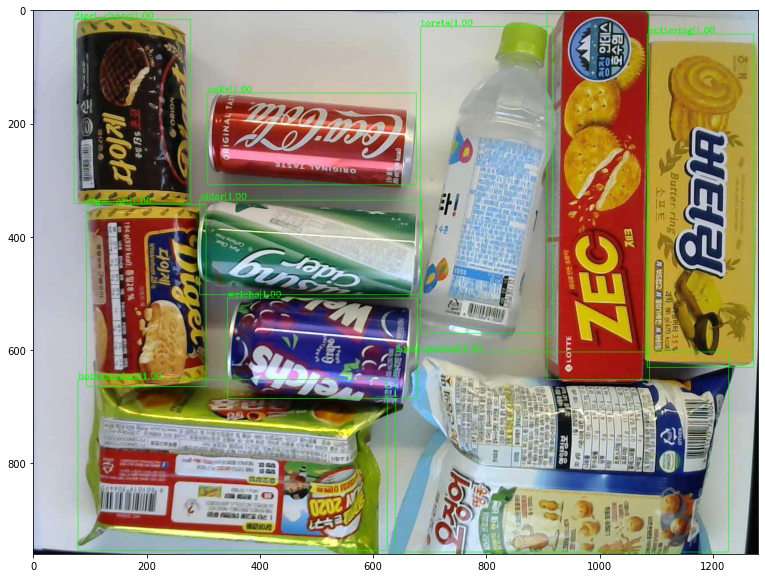

In [6]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('datasets/train/images/0046.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [7]:
torch.save(model.state_dict(), 'save_state_dict/DetectoRS_model_state_dict.pt')

In [8]:
torch.save(model, 'save_model/DetectoRS_model.pt')